In [1]:
import pandas as pd

# Load the dataset
df = pd.read_excel('sample_customer_database_5000_singapore.xlsx')


In [2]:
# First look at the data
print(df.head())  # First 5 rows

  Customer ID        Full Name                Email Address  Phone Number  \
0       C0001     Norma Fisher          ysullivan@yahoo.com      82421948   
1       C0002      Levi Durham            qgrimes@gmail.com      97535139   
2       C0003   Kimberly Olsen  sean96@johnston-roberts.com      71122018   
3       C0004   Matthew Davies    nguyendarrell@hotmail.com      41352560   
4       C0005  Angela Martinez    myersmitchell@johnson.com        869141   

  Date Joined     Location  Gender Loyalty Tier  \
0  2023-08-11     Tampines  Female     Platinum   
1  2022-11-24      Geylang  Female     Platinum   
2  2023-06-19     Tampines  Female     Platinum   
3  2025-04-04   Ang Mo Kio    Male       Silver   
4  2025-01-15  Bukit Batok  Female     Platinum   

                                               Notes  
0                        Together range line beyond.  
1  Language ball floor meet usually board necessary.  
2                 Support time operation wear often.  
3         

In [3]:
import numpy
import pandas

print("NumPy version:", numpy.__version__)
print("Pandas version:", pandas.__version__)


NumPy version: 1.26.4
Pandas version: 2.2.3


In [4]:
# Shape of the dataset
print("Shape of dataset:", df.shape)

Shape of dataset: (5000, 9)


In [5]:
# Columns and Data types
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Customer ID    5000 non-null   object        
 1   Full Name      5000 non-null   object        
 2   Email Address  5000 non-null   object        
 3   Phone Number   5000 non-null   int64         
 4   Date Joined    5000 non-null   datetime64[ns]
 5   Location       5000 non-null   object        
 6   Gender         5000 non-null   object        
 7   Loyalty Tier   5000 non-null   object        
 8   Notes          5000 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 351.7+ KB
None


In [6]:
# Check for missing values
print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 Customer ID      0
Full Name        0
Email Address    0
Phone Number     0
Date Joined      0
Location         0
Gender           0
Loyalty Tier     0
Notes            0
dtype: int64


In [7]:
# Check for duplicate rows
print("Number of duplicate rows:", df.duplicated().sum())

Number of duplicate rows: 0


In [8]:
# Unique values per column
print("Unique values per column:\n", df.nunique())

Unique values per column:
 Customer ID      5000
Full Name        4835
Email Address    4983
Phone Number     4998
Date Joined      1084
Location           27
Gender              2
Loyalty Tier        3
Notes            5000
dtype: int64


In [21]:
# Ensure 'Date_Joined' is in datetime format
df['Date Joined'] = pd.to_datetime(df['Date Joined'], errors='coerce')

# Today's date
today = pd.to_datetime("today")

# Feature Engineering from Date_Joined
df['Days_Since_Joined'] = (today - df['Date Joined']).dt.days
df['Join_Year'] = df['Date Joined'].dt.year
df['Join_Month'] = df['Date Joined'].dt.month
df['Join_Quarter'] = df['Date Joined'].dt.quarter
df['Is_New'] = (df['Days_Since_Joined'] <= 180).astype(int)

# Display engineered features
df[['Date Joined', 'Days_Since_Joined', 'Join_Year', 'Join_Month', 'Join_Quarter', 'Is_New']].head()


,Date Joined,Days_Since_Joined,Join_Year,Join_Month,Join_Quarter,Is_New
0,2023-08-11,648,2023,8,3,0
1,2022-11-24,908,2022,11,4,0
2,2023-06-19,701,2023,6,2,0
3,2025-04-04,46,2025,4,2,1
4,2025-01-15,125,2025,1,1,1


In [22]:
# Save for reuse
categorical_cols = [
    'Location',
    'Gender',
    'Loyalty Tier',
    'Join_Year',
    'Join_Month',
    'Join_Quarter',
    'Is_New'
]

numerical_cols = [
    'Days_Since_Joined'
]


In [36]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import rbf_kernel
import numpy as np

# Define features
categorical_cols = [
    'Location', 'Gender', 'Loyalty Tier',
    'Join_Year', 'Join_Month', 'Join_Quarter', 'Is_New'
]
numerical_cols = ['Days_Since_Joined']

# Encode categorical
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cat_encoded = encoder.fit_transform(df[categorical_cols])

# Scale numerical
scaler = StandardScaler()
num_scaled = scaler.fit_transform(df[numerical_cols])

# Combine: [categorical | numerical]
combined_features = np.hstack([cat_encoded, num_scaled])

# PCA + RBF + Spectral
from sklearn.decomposition import PCA
X_pca = PCA(n_components=30).fit_transform(combined_features)
affinity_matrix = rbf_kernel(X_pca, gamma=0.5)

# Spectral Clustering
spectral = SpectralClustering(n_clusters=5, affinity='precomputed', random_state=42)
df['CatNum_Spectral_Label'] = spectral.fit_predict(affinity_matrix)

# Evaluation
score = silhouette_score(combined_features, df['CatNum_Spectral_Label'])
print("✅ Model 1 – Categorical + Numerical (Spectral)")
print("Silhouette Score:", score)


✅ Model 1 – Categorical + Numerical (Spectral)
Silhouette Score: 0.1560461057802064


In [13]:
# Display Spectral Clustering results for CATEGORICAL
print("\n📊 Spectral Clustering (Categorical) — Cluster Counts")
print(df['Cat_Spectral_Label'].value_counts())

print("\n🏷️ Sample Records per Categorical Cluster")
for i in sorted(df['Cat_Spectral_Label'].unique()):
    print(f"\n--- Cluster {i} ---")
    print(df[df['Cat_Spectral_Label'] == i][['Location', 'Gender', 'Loyalty Tier']].head(3).to_string(index=False))



📊 Spectral Clustering (Categorical) — Cluster Counts
Cat_Spectral_Label
1    1243
2    1228
4    1010
0     780
3     739
Name: count, dtype: int64

🏷️ Sample Records per Categorical Cluster

--- Cluster 0 ---
   Location Gender Loyalty Tier
    Punggol Female         Gold
Jurong East Female         Gold
   Clementi Female         Gold

--- Cluster 1 ---
  Location Gender Loyalty Tier
Ang Mo Kio   Male       Silver
  Tampines   Male       Silver
 Pasir Ris   Male       Silver

--- Cluster 2 ---
   Location Gender Loyalty Tier
Bukit Batok Female       Silver
      Bedok Female       Silver
  Woodlands Female       Silver

--- Cluster 3 ---
     Location Gender Loyalty Tier
Choa Chu Kang   Male         Gold
     Tampines   Male         Gold
     Tampines   Male         Gold

--- Cluster 4 ---
Location Gender Loyalty Tier
Tampines Female     Platinum
 Geylang Female     Platinum
Tampines Female     Platinum


In [40]:
from sklearn.preprocessing import OneHotEncoder
import umap
import hdbscan
import numpy as np
from sklearn.metrics import silhouette_score

# Step 0: Define categorical columns
categorical_cols = [
    'Location', 'Gender', 'Loyalty Tier',
    'Join_Year', 'Join_Month', 'Join_Quarter', 'Is_New'
]

# Step 1: One-Hot Encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cat_encoded = encoder.fit_transform(df[categorical_cols])

# Step 2: UMAP for dimensionality reduction
cat_embed = umap.UMAP(
    n_neighbors=70,      # try 15, 30, 50
    min_dist=0.1,        # try 0.05, 0.3
    n_components=10,     # dimensionality of embedding
    random_state=42
).fit_transform(cat_encoded)

# Step 3: HDBSCAN Clustering
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=50,   # try 10, 15, 20
    min_samples=15,         # try 3, 5, 10
    prediction_data=True
)
df['HDBSCAN_Cat_Label'] = clusterer.fit_predict(cat_embed)

# Step 4: Evaluation
mask = df['HDBSCAN_Cat_Label'] != -1
if mask.sum() > 1:
    silhouette = silhouette_score(cat_embed[mask], df.loc[mask, 'HDBSCAN_Cat_Label'])
    print("✅ UMAP + HDBSCAN (Categorical) Silhouette Score:", silhouette)
else:
    print("⚠️ Too much noise – Silhouette Score not computed")

# Step 5: Show cluster count
n_clusters = len(np.unique(df['HDBSCAN_Cat_Label'])) - (1 if -1 in df['HDBSCAN_Cat_Label'] else 0)
print(f"📊 Number of clusters (excluding noise): {n_clusters}")

# Optional: Preview first few labels
print(df[['HDBSCAN_Cat_Label']].head())



c:\Users\Lenovo\Downloads\Year 3 Major project\marketing-portal\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lenovo\Downloads\Year 3 Major project\marketing-portal\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Lenovo\Downloads\Year 3 Major project\marketing-portal\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lenovo\Downloads\Year 3 Major project\marketing-portal\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ UMAP + HDBSCAN (Categorical) Silhouette Score: 0.7607955
📊 Number of clusters (excluding noise): 11
   HDBSCAN_Cat_Label
0                  0
1                  2
2                  3
3                  7
4                  8


In [81]:
df_clean = df[df['HDBSCAN_CatNum_Label'] != -1]


In [82]:
cluster_profiles = df_clean.groupby('HDBSCAN_CatNum_Label').agg({
    'Days_Since_Joined': ['mean', 'min', 'max'],
    'Gender': lambda x: x.value_counts(normalize=True).to_dict(),
    'Loyalty Tier': lambda x: x.value_counts(normalize=True).to_dict(),
    'Location': lambda x: x.value_counts().head(3).to_dict(),
    'Is_New': 'mean'
})


In [83]:
# Flatten multi-index columns
cluster_profiles.columns = ['_'.join(col).strip() for col in cluster_profiles.columns.values]
cluster_profiles.reset_index(inplace=True)


In [88]:

cluster_profiles.to_csv("cluster_profiles.csv", index=False)


c:\Users\Lenovo\Downloads\Year 3 Major project\marketing-portal\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lenovo\Downloads\Year 3 Major project\marketing-portal\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_36936\1279218361.py:16: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Lenovo\Downloads\Year 3 Major project\marketing-portal\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


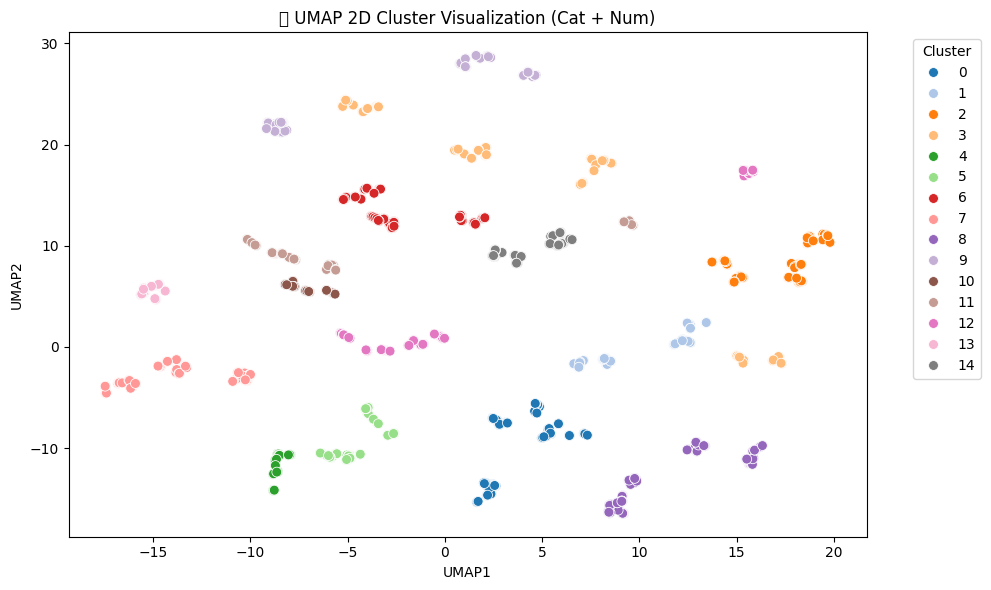

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_36936\1279218361.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_36936\1279218361.py:27: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Lenovo\Downloads\Year 3 Major project\marketing-portal\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


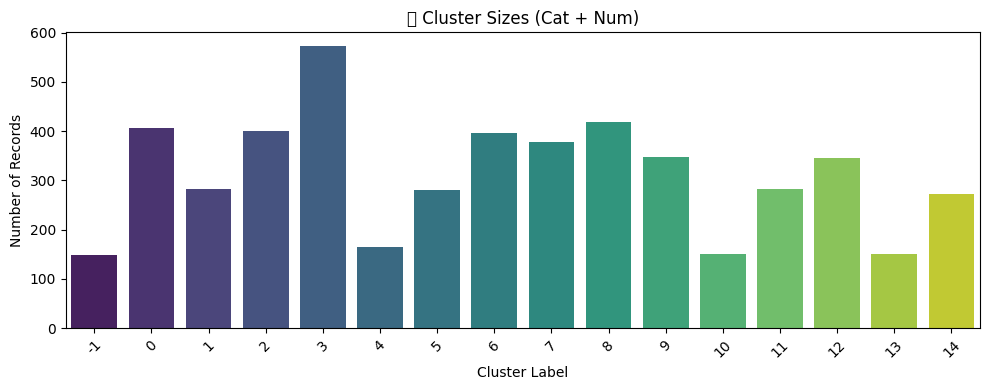

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_36936\1279218361.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['HDBSCAN_CatNum_Label'] != -1], x='HDBSCAN_CatNum_Label', y='Days_Since_Joined', palette='Set3')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_36936\1279218361.py:36: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Lenovo\Downloads\Year 3 Major project\marketing-portal\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


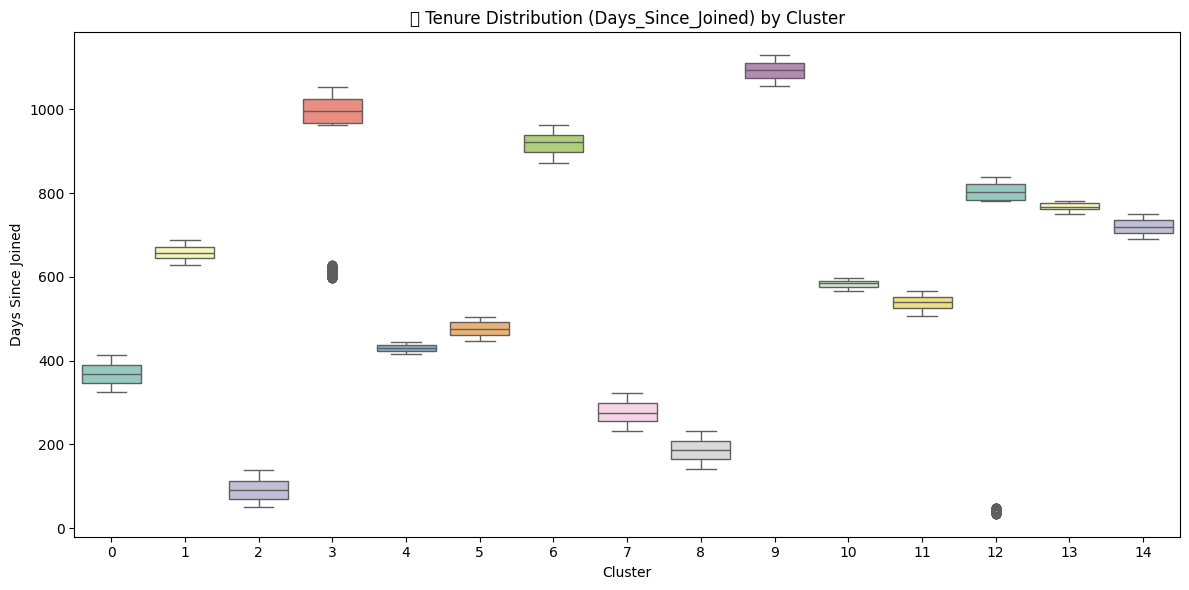

In [74]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# Recreate UMAP 2D projection using categorical + numerical combined features
umap_2d = umap.UMAP(n_components=2, random_state=42).fit_transform(combined_features)
df['UMAP1'] = umap_2d[:, 0]
df['UMAP2'] = umap_2d[:, 1]

# 1. 📌 UMAP 2D Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df[df['HDBSCAN_CatNum_Label'] != -1], x='UMAP1', y='UMAP2',
                hue='HDBSCAN_CatNum_Label', palette='tab20', legend='full', s=50)
plt.title("📌 UMAP 2D Cluster Visualization (Cat + Num)")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 2. 📊 Bar Chart — Cluster Sizes
plt.figure(figsize=(10, 4))
cluster_counts = df['HDBSCAN_CatNum_Label'].value_counts().sort_index()
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.title("📊 Cluster Sizes (Cat + Num)")
plt.xlabel("Cluster Label")
plt.ylabel("Number of Records")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. 📦 Boxplot — Days_Since_Joined by Cluster
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[df['HDBSCAN_CatNum_Label'] != -1], x='HDBSCAN_CatNum_Label', y='Days_Since_Joined', palette='Set3')
plt.title("📦 Tenure Distribution (Days_Since_Joined) by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Days Since Joined")
plt.tight_layout()
plt.show()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_36936\2114913009.py:12: UserWarning: Glyph 127894 (\N{MILITARY MEDAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Lenovo\Downloads\Year 3 Major project\marketing-portal\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127894 (\N{MILITARY MEDAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


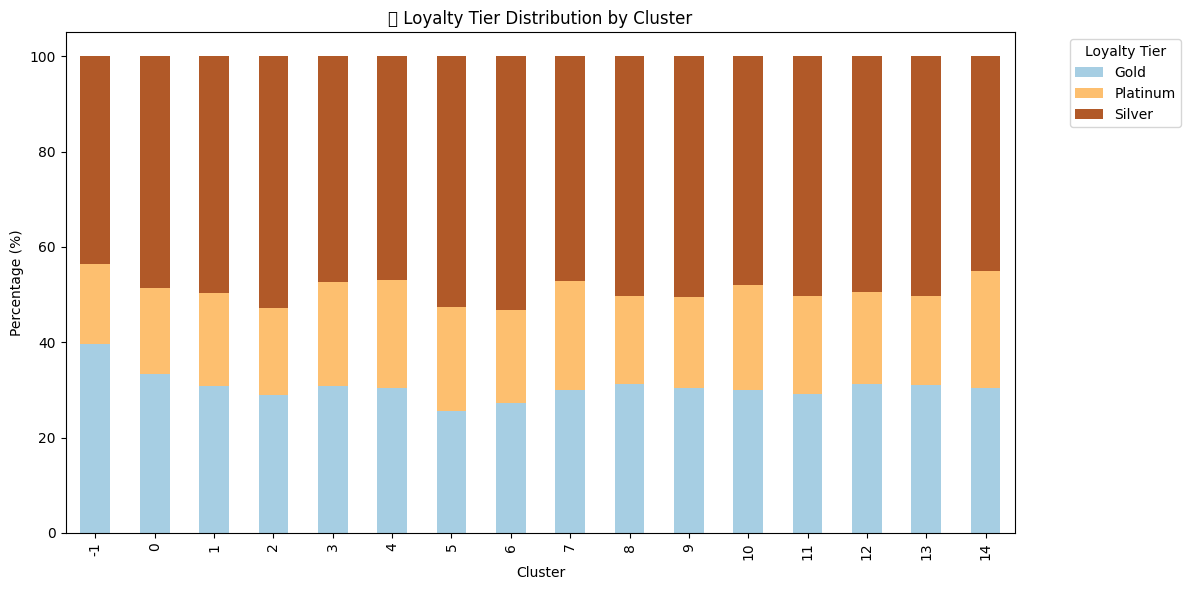

In [75]:
# Loyalty Tier by Cluster (Stacked % Bar)
import pandas as pd
import matplotlib.pyplot as plt

loyalty_dist = pd.crosstab(df['HDBSCAN_CatNum_Label'], df['Loyalty Tier'], normalize='index') * 100
loyalty_dist.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Paired')

plt.title("🎖️ Loyalty Tier Distribution by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Percentage (%)")
plt.legend(title="Loyalty Tier", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_36936\846555803.py:9: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Lenovo\Downloads\Year 3 Major project\marketing-portal\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


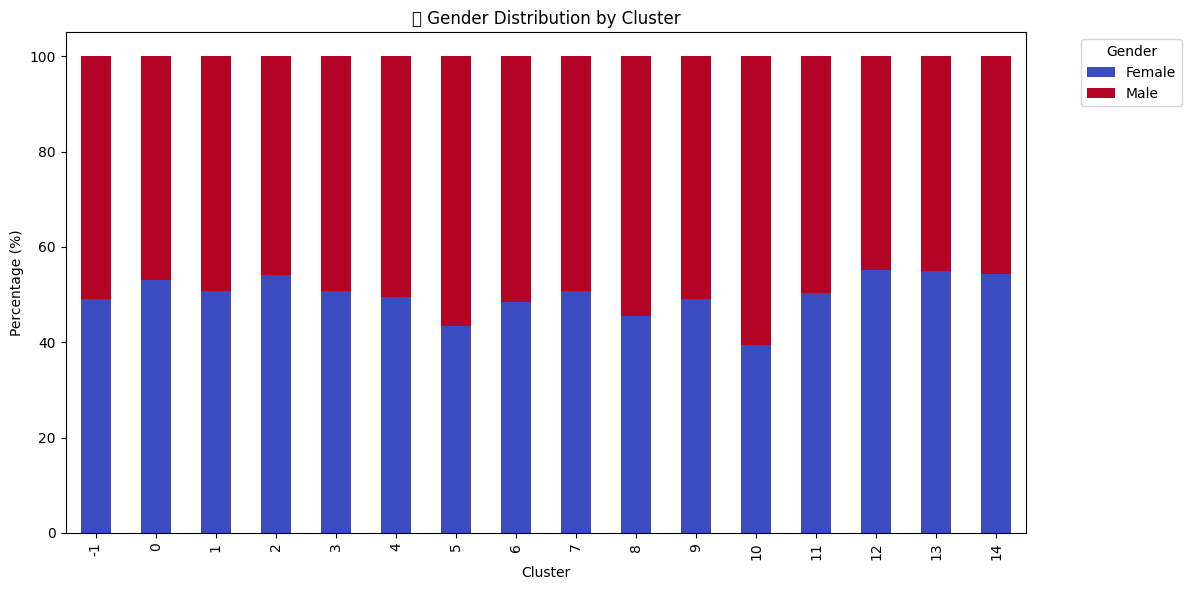

In [76]:
# Gender Distribution per Cluster
gender_dist = pd.crosstab(df['HDBSCAN_CatNum_Label'], df['Gender'], normalize='index') * 100
gender_dist.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='coolwarm')

plt.title("👥 Gender Distribution by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Percentage (%)")
plt.legend(title="Gender", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_36936\4009135173.py:9: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Lenovo\Downloads\Year 3 Major project\marketing-portal\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


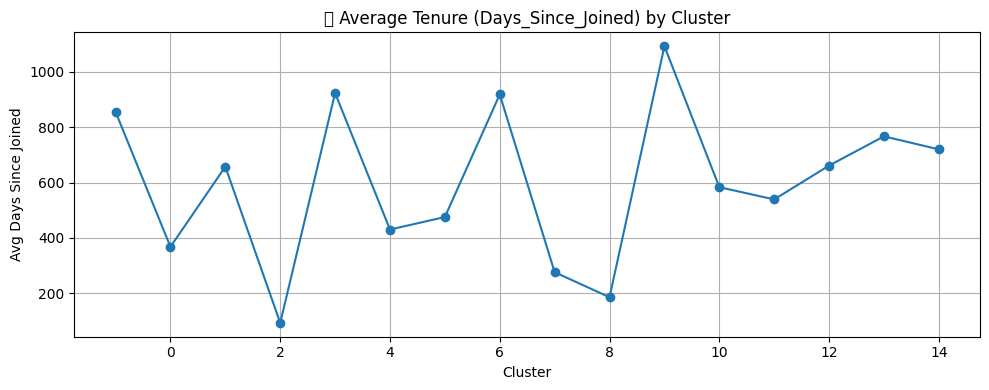

In [78]:
# Mean Tenure per Cluster (Days_Since_Joined)
tenure_avg = df.groupby('HDBSCAN_CatNum_Label')['Days_Since_Joined'].mean()

tenure_avg.plot(kind='line', marker='o', figsize=(10, 4))
plt.title("📈 Average Tenure (Days_Since_Joined) by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Avg Days Since Joined")
plt.grid(True)
plt.tight_layout()
plt.show()


In [71]:
def summarize_clusters(df, label_col, title):
    cluster_ids = sorted(df[label_col].dropna().unique())
    for cid in cluster_ids:
        if cid == -1:
            continue  # skip noise
        print(f"\n🧩 {title} {cid} — Sample Records:")
        display(df[df[label_col] == cid][[
            'Location', 'Gender', 'Loyalty Tier',
            'Join_Year', 'Join_Month', 'Join_Quarter', 'Is_New',
            'Days_Since_Joined'
        ]].head(3))

# 📦 Print Categorical-Only Clusters
if 'HDBSCAN_Cat_Label' in df.columns:
    summarize_clusters(df, 'HDBSCAN_Cat_Label', "Cat_Only Cluster")
else:
    print("⚠️ HDBSCAN_Cat_Label not found. Please run the categorical-only model first.")

# 📦 Print Cat + Num Clusters
if 'HDBSCAN_CatNum_Label' in df.columns:
    summarize_clusters(df, 'HDBSCAN_CatNum_Label', "Cat+Num Cluster")
else:
    print("⚠️ HDBSCAN_CatNum_Label not found. Please run the cat+num model first.")



🧩 Cat_Only Cluster 0 — Sample Records:


,Location,Gender,Loyalty Tier,Join_Year,Join_Month,Join_Quarter,Is_New,Days_Since_Joined
0,Tampines,Female,Platinum,2023,8,3,0,648
7,Bedok,Female,Silver,2022,9,3,0,978
24,Punggol,Female,Gold,2023,7,3,0,667



🧩 Cat_Only Cluster 1 — Sample Records:


,Location,Gender,Loyalty Tier,Join_Year,Join_Month,Join_Quarter,Is_New,Days_Since_Joined
9,Pasir Ris,Male,Silver,2023,8,3,0,651
10,Yishun,Male,Platinum,2024,7,3,0,323
11,Bukit Timah,Male,Silver,2024,8,3,0,281



🧩 Cat_Only Cluster 2 — Sample Records:


,Location,Gender,Loyalty Tier,Join_Year,Join_Month,Join_Quarter,Is_New,Days_Since_Joined
1,Geylang,Female,Platinum,2022,11,4,0,908
12,Central Area,Male,Silver,2023,11,4,0,541
19,Bishan,Male,Silver,2023,12,4,0,510



🧩 Cat_Only Cluster 3 — Sample Records:


,Location,Gender,Loyalty Tier,Join_Year,Join_Month,Join_Quarter,Is_New,Days_Since_Joined
2,Tampines,Female,Platinum,2023,6,2,0,701
14,Punggol,Female,Silver,2024,5,2,0,365
15,Queenstown,Male,Platinum,2022,6,2,0,1070



🧩 Cat_Only Cluster 4 — Sample Records:


,Location,Gender,Loyalty Tier,Join_Year,Join_Month,Join_Quarter,Is_New,Days_Since_Joined
48,Clementi,Male,Gold,2023,1,1,0,868
53,Toa Payoh,Male,Silver,2023,1,1,0,852
87,Hougang,Male,Silver,2023,1,1,0,854



🧩 Cat_Only Cluster 5 — Sample Records:


,Location,Gender,Loyalty Tier,Join_Year,Join_Month,Join_Quarter,Is_New,Days_Since_Joined
30,Central Area,Male,Silver,2024,12,4,1,150
37,Marine Parade,Male,Platinum,2024,12,4,1,142
47,Toa Payoh,Male,Silver,2024,12,4,1,154



🧩 Cat_Only Cluster 6 — Sample Records:


,Location,Gender,Loyalty Tier,Join_Year,Join_Month,Join_Quarter,Is_New,Days_Since_Joined
5,Tampines,Male,Silver,2024,3,1,0,418
16,Bukit Panjang,Male,Silver,2024,2,1,0,460
21,Toa Payoh,Male,Platinum,2024,1,1,0,503



🧩 Cat_Only Cluster 7 — Sample Records:


,Location,Gender,Loyalty Tier,Join_Year,Join_Month,Join_Quarter,Is_New,Days_Since_Joined
3,Ang Mo Kio,Male,Silver,2025,4,2,1,46
6,Bukit Batok,Female,Silver,2025,4,2,1,39
8,Woodlands,Female,Silver,2025,4,2,1,40



🧩 Cat_Only Cluster 8 — Sample Records:


,Location,Gender,Loyalty Tier,Join_Year,Join_Month,Join_Quarter,Is_New,Days_Since_Joined
4,Bukit Batok,Female,Platinum,2025,1,1,1,125
25,Central Area,Female,Silver,2025,3,1,1,72
39,Queenstown,Male,Silver,2025,1,1,1,133



🧩 Cat_Only Cluster 9 — Sample Records:


,Location,Gender,Loyalty Tier,Join_Year,Join_Month,Join_Quarter,Is_New,Days_Since_Joined
13,Clementi,Female,Silver,2024,1,1,0,480
26,Jurong East,Female,Gold,2024,2,1,0,449
71,Yishun,Female,Gold,2024,1,1,0,478



🧩 Cat_Only Cluster 10 — Sample Records:


,Location,Gender,Loyalty Tier,Join_Year,Join_Month,Join_Quarter,Is_New,Days_Since_Joined
41,Marine Parade,Female,Gold,2023,1,1,0,849
57,Punggol,Female,Silver,2023,2,1,0,824
85,Queenstown,Female,Platinum,2023,2,1,0,818



🧩 Cat+Num Cluster 0 — Sample Records:


,Location,Gender,Loyalty Tier,Join_Year,Join_Month,Join_Quarter,Is_New,Days_Since_Joined
14,Punggol,Female,Silver,2024,5,2,0,365
22,Queenstown,Female,Platinum,2024,4,2,0,397
27,Yishun,Male,Silver,2024,6,2,0,331



🧩 Cat+Num Cluster 1 — Sample Records:


,Location,Gender,Loyalty Tier,Join_Year,Join_Month,Join_Quarter,Is_New,Days_Since_Joined
0,Tampines,Female,Platinum,2023,8,3,0,648
9,Pasir Ris,Male,Silver,2023,8,3,0,651
24,Punggol,Female,Gold,2023,7,3,0,667



🧩 Cat+Num Cluster 2 — Sample Records:


,Location,Gender,Loyalty Tier,Join_Year,Join_Month,Join_Quarter,Is_New,Days_Since_Joined
4,Bukit Batok,Female,Platinum,2025,1,1,1,125
25,Central Area,Female,Silver,2025,3,1,1,72
39,Queenstown,Male,Silver,2025,1,1,1,133



🧩 Cat+Num Cluster 3 — Sample Records:


,Location,Gender,Loyalty Tier,Join_Year,Join_Month,Join_Quarter,Is_New,Days_Since_Joined
7,Bedok,Female,Silver,2022,9,3,0,978
18,Marine Parade,Male,Platinum,2022,8,3,0,1008
45,Novena,Male,Silver,2022,9,3,0,967



🧩 Cat+Num Cluster 4 — Sample Records:


,Location,Gender,Loyalty Tier,Join_Year,Join_Month,Join_Quarter,Is_New,Days_Since_Joined
5,Tampines,Male,Silver,2024,3,1,0,418
40,Toa Payoh,Male,Silver,2024,3,1,0,428
112,Punggol,Male,Silver,2024,3,1,0,427



🧩 Cat+Num Cluster 5 — Sample Records:


,Location,Gender,Loyalty Tier,Join_Year,Join_Month,Join_Quarter,Is_New,Days_Since_Joined
13,Clementi,Female,Silver,2024,1,1,0,480
16,Bukit Panjang,Male,Silver,2024,2,1,0,460
21,Toa Payoh,Male,Platinum,2024,1,1,0,503



🧩 Cat+Num Cluster 6 — Sample Records:


,Location,Gender,Loyalty Tier,Join_Year,Join_Month,Join_Quarter,Is_New,Days_Since_Joined
1,Geylang,Female,Platinum,2022,11,4,0,908
49,Bukit Panjang,Male,Silver,2022,11,4,0,921
58,Bedok,Male,Silver,2022,12,4,0,888



🧩 Cat+Num Cluster 7 — Sample Records:


,Location,Gender,Loyalty Tier,Join_Year,Join_Month,Join_Quarter,Is_New,Days_Since_Joined
10,Yishun,Male,Platinum,2024,7,3,0,323
11,Bukit Timah,Male,Silver,2024,8,3,0,281
31,Novena,Male,Platinum,2024,9,3,0,252



🧩 Cat+Num Cluster 8 — Sample Records:


,Location,Gender,Loyalty Tier,Join_Year,Join_Month,Join_Quarter,Is_New,Days_Since_Joined
28,Punggol,Female,Silver,2024,10,4,0,225
30,Central Area,Male,Silver,2024,12,4,1,150
37,Marine Parade,Male,Platinum,2024,12,4,1,142



🧩 Cat+Num Cluster 9 — Sample Records:


,Location,Gender,Loyalty Tier,Join_Year,Join_Month,Join_Quarter,Is_New,Days_Since_Joined
15,Queenstown,Male,Platinum,2022,6,2,0,1070
17,Sembawang,Male,Silver,2022,5,2,0,1086
32,Bukit Timah,Male,Silver,2022,5,2,0,1087



🧩 Cat+Num Cluster 10 — Sample Records:


,Location,Gender,Loyalty Tier,Join_Year,Join_Month,Join_Quarter,Is_New,Days_Since_Joined
29,Choa Chu Kang,Male,Gold,2023,10,4,0,572
76,Ang Mo Kio,Male,Silver,2023,10,4,0,595
134,Bukit Merah,Male,Gold,2023,10,4,0,570



🧩 Cat+Num Cluster 11 — Sample Records:


,Location,Gender,Loyalty Tier,Join_Year,Join_Month,Join_Quarter,Is_New,Days_Since_Joined
12,Central Area,Male,Silver,2023,11,4,0,541
19,Bishan,Male,Silver,2023,12,4,0,510
46,Bukit Batok,Female,Platinum,2023,11,4,0,547



🧩 Cat+Num Cluster 12 — Sample Records:


,Location,Gender,Loyalty Tier,Join_Year,Join_Month,Join_Quarter,Is_New,Days_Since_Joined
3,Ang Mo Kio,Male,Silver,2025,4,2,1,46
6,Bukit Batok,Female,Silver,2025,4,2,1,39
8,Woodlands,Female,Silver,2025,4,2,1,40



🧩 Cat+Num Cluster 13 — Sample Records:


,Location,Gender,Loyalty Tier,Join_Year,Join_Month,Join_Quarter,Is_New,Days_Since_Joined
120,Serangoon,Male,Platinum,2023,4,2,0,778
153,Queenstown,Female,Platinum,2023,4,2,0,769
172,Bukit Timah,Female,Silver,2023,4,2,0,764



🧩 Cat+Num Cluster 14 — Sample Records:


,Location,Gender,Loyalty Tier,Join_Year,Join_Month,Join_Quarter,Is_New,Days_Since_Joined
2,Tampines,Female,Platinum,2023,6,2,0,701
20,Sengkang,Male,Silver,2023,5,2,0,731
54,Queenstown,Female,Platinum,2023,6,2,0,711


In [70]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import umap
import hdbscan
import numpy as np
from sklearn.metrics import silhouette_score

# Step 0: Define columns
categorical_cols = [
    'Location', 'Gender', 'Loyalty Tier',
    'Join_Year', 'Join_Month', 'Join_Quarter', 'Is_New'
]
numerical_cols = ['Days_Since_Joined']

# Step 1: Encode categorical
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cat_encoded = encoder.fit_transform(df[categorical_cols])

# Step 2: Scale numerical
scaler = StandardScaler()
num_scaled = scaler.fit_transform(df[numerical_cols])

# Step 3: Combine features
combined_features = np.hstack([cat_encoded, num_scaled])

# Step 4: UMAP
embed = umap.UMAP(
    n_neighbors=70,
    min_dist=0.1,
    n_components=10,
    random_state=42
).fit_transform(combined_features)

# Step 5: HDBSCAN
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=150,
    min_samples=15,
    prediction_data=True
)
df['HDBSCAN_CatNum_Label'] = clusterer.fit_predict(embed)

# Step 6: Evaluation
mask = df['HDBSCAN_CatNum_Label'] != -1
if mask.sum() > 1:
    silhouette = silhouette_score(embed[mask], df.loc[mask, 'HDBSCAN_CatNum_Label'])
    print("✅ UMAP + HDBSCAN (Cat + Num) Silhouette Score:", silhouette)
else:
    print("⚠️ Too much noise – Silhouette Score not computed")

# Step 7: Cluster count
n_clusters = len(np.unique(df['HDBSCAN_CatNum_Label'])) - (1 if -1 in df['HDBSCAN_CatNum_Label'] else 0)
print(f"📊 Number of clusters (excluding noise): {n_clusters}")

# Optional: Preview
print(df[['HDBSCAN_CatNum_Label']].head())


c:\Users\Lenovo\Downloads\Year 3 Major project\marketing-portal\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lenovo\Downloads\Year 3 Major project\marketing-portal\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Lenovo\Downloads\Year 3 Major project\marketing-portal\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lenovo\Downloads\Year 3 Major project\marketing-portal\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ UMAP + HDBSCAN (Cat + Num) Silhouette Score: 0.73693943
📊 Number of clusters (excluding noise): 16
   HDBSCAN_CatNum_Label
0                     1
1                     6
2                    14
3                    12
4                     2


In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import silhouette_score
import gower
import numpy as np
from sklearn.cluster import AgglomerativeClustering

# Step 1: Define features
categorical_cols = ['Location', 'Gender', 'Loyalty Tier', 'Join_Year', 'Join_Month', 'Join_Quarter', 'Is_New']
numerical_cols = ['Days_Since_Joined']
feature_cols = categorical_cols + numerical_cols

# Step 2: Compute Gower distance matrix for clustering
gower_dist = np.array(gower.gower_matrix(df[feature_cols]))
gower_dist[np.arange(len(gower_dist)), np.arange(len(gower_dist))] = 0.0  # Safety check

# Step 3: Agglomerative Clustering using Gower
agglo = AgglomerativeClustering(n_clusters=7, metric='precomputed', linkage='average')

df['Gower_Agglo_Label'] = agglo.fit_predict(gower_dist)

# Step 4: Encode categorical columns for silhouette score
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cat_encoded = encoder.fit_transform(df[categorical_cols])

# Scale numerical column
scaler = StandardScaler()
num_scaled = scaler.fit_transform(df[numerical_cols])

# Combine encoded features
combined_encoded = np.hstack([cat_encoded, num_scaled])

# Step 5: Silhouette on encoded feature space
labels = df['Gower_Agglo_Label'].values
if len(np.unique(labels)) > 1:
    silhouette = silhouette_score(combined_encoded, labels, metric='euclidean')
    print("✅ Silhouette Score (Encoded features):", silhouette)
else:
    print("⚠️ Not enough clusters to compute silhouette.")

# Step 6: Output sample
print(df[['Location', 'Gender', 'Loyalty Tier', 'Gower_Agglo_Label']].head())


✅ Silhouette Score (Encoded features): 0.06624644160321085
      Location  Gender Loyalty Tier  Gower_Agglo_Label
0     Tampines  Female     Platinum                  1
1      Geylang  Female     Platinum                  1
2     Tampines  Female     Platinum                  1
3   Ang Mo Kio    Male       Silver                  5
4  Bukit Batok  Female     Platinum                  5
